# I-STL Overview 

- Add a brief description here

### 1. Set imports and read in data 

- `lat_n and lon_n` correspond to the latitude and longitude lists of agent n for plotting 
- `t` is the timestep array 
- `x_n` is the signal for agent n that we will use to compute robustness 
    - In this example, `x_n` is a numpy array of size (t, 2) that consists of t rows of [lat_n, lon_n] @ time t

In [55]:
import numpy as np
import sympy as sp
import time
import interval
from inclusion import NaturalInclusionFunction
import matplotlib.animation as animation
from scipy.io import loadmat
from stlpy.STL import LinearPredicate, NonlinearPredicate
from matplotlib import pyplot as plt
from matplotlib import rc
import pickle 

rc('text', usetex=True)

# Part 1: Un-pickling and loading MITLL data 
with open('sim_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Get all the GCS values for agent 1 

lat_1 = []
lon_1 = []
alt_1 = []

# And agent 4 
lat_4 = []
lon_4 = []
alt_4 = []

# Signal and time lists 
x1 = [] 
x4 = []
t = []

for timestamp in data:

    # Original code sets up all agents in case we want to build on specs (i.e. don't crash, etc.)
    t.append(timestamp[0]) 
    lat_1.append(timestamp[1][1]["lat"])
    lon_1.append(timestamp[1][1]["lon"])
    x1.append([timestamp[1][1]["lat"], timestamp[1][1]["lon"]])

    lat_4.append(timestamp[1][4]["lat"])
    lon_4.append(timestamp[1][4]["lon"])
    x4.append([timestamp[1][4]["lat"], timestamp[1][4]["lon"]])

# Our signal- just lat and lon position 
t = np.array(t)
x1 = np.array(x1)
x4 = np.array(x4)
print(x1.shape)
print(x4.shape)
print(t.shape)
nt = t.shape[0]



(1800, 2)
(1800, 2)
(1800,)


### 2. Set up the specification

- In this case we want the agent's lat and lon position to fall within the bounding box specified below within a certain timestep interval.
- Bounding box set by identifying center point of [lat, lon] and applying offset of 0.0001 in each direction. 

Note: I will fix the axis limit issues of the plot below 

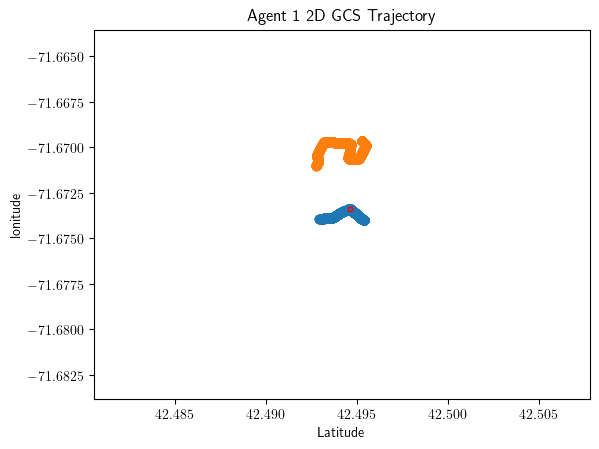

In [56]:
offset = 0.0001
lat_center = 42.49464
lon_center = -71.6734

# 2D Trajectory Plot
plt.figure()
plt.title("Agent 1 2D GCS Trajectory")
plt.xlabel("Latitude")
plt.ylabel("lonitude")
plt.axis('equal')

square = plt.Rectangle((lat_center - offset, lon_center - offset), 2*offset, 2*offset, facecolor='none', ec="red")
plt.gca().add_patch(square)
plt.scatter(lat_1, lon_1)
plt.scatter(lat_4, lon_4)
plt.show()


Now set up the bounding box specification: 

1. Specify the agent position requirements: 

$c_{lat} - offset < p{lat} < c_{lat} + offset $ and $c_{lon} - offset < p{lon} < c_{lon} + offset $

2. Create a linear predicate based on each requirement from the linear predicate equation: 

$a^Ty_t - b \geqq 0$

where $a$ is a multiplication matrix for signal $y$


In [57]:
a_lat = np.array([1,0]) #Signal multiplier- will be useful once other variables are included in spec
a_long = np.array([0,1])

left = LinearPredicate(a_lat, lat_center - offset) 
right = LinearPredicate(-a_lat, -lat_center - offset) 
top = LinearPredicate(-a_long, -lon_center - offset)
bottom = LinearPredicate(a_long, lon_center - offset)


square_spec = left & right & top & bottom
# Note: these times do not correspond to exact offset points as they need to be ints- originals 51.3, 58.2
# pi = square_spec.always(513, 582) # times determined manually - I might change this in the future
pi = square_spec.always(513, 582)

## 3. Set up interval analysis 
- add the uncertainty
- If time put equations and stuff 

In [58]:
# Create an uncertainty for each of the values.
eps = np.array([0.0000005, 0.0000005]) #* 10 
epsilon = interval.get_iarray(-1*eps, eps)

x1_no_uncertainty = x1.copy()
x1 = x1 + epsilon # Add uncertainty. For a "no uncertainty" version, comment this line.
x4_no_uncertainty = x4.copy()
x4 = x4 + epsilon


## 4. Compute the robustness vector
- In this case it will only be one value, but we can also set up the spec to evaluate relatively as well 

In [59]:
rho1 = []
rho4 = []
robustness_start_time = time.time() # For reporting the computation time.

for j in range(nt):
    rho1.append(pi.robustness((x1.T), 0)) 
    rho4.append(pi.robustness((x4.T), 0)) 

print("--- Robustness computation took %s seconds ---" % (time.time() - robustness_start_time))
nt1 = len(rho1)
rho1 = np.array(rho1)
nt4 = len(rho4)
rho4 = np.array(rho4)

--- Robustness computation took 6.474612474441528 seconds ---


## 5. Plot 

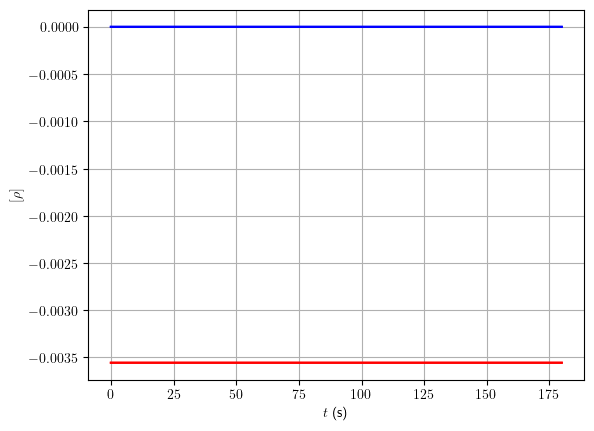

In [60]:
# For plotting, convert rho back to two values
_rho1, rho1_ = interval.get_lu(rho1)
_rho4, rho4_ = interval.get_lu(rho4)

rho_fig, rho_axes = plt.subplots()
rho_axes.ticklabel_format(useOffset=False, style='plain')
rho_fig.subplots_adjust()
rho_axes.plot(t,  _rho1, 'b')
rho_axes.plot(t, rho1_, 'b')
rho_axes.fill_between(t, _rho1, rho1_, facecolor='b', alpha=.25)
rho_axes.plot(t,  _rho4, 'r')
rho_axes.plot(t, rho4_, 'r')
rho_axes.fill_between(t, _rho4, rho4_, facecolor='r', alpha=.25)
rho_axes.set_ylabel('$[\\rho]$')
rho_axes.set_xlabel('$t$ (s)')
rho_axes.grid(True)